In [1]:
# a bit of setup
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
import utils

from sklearn.neighbors import KernelDensity
from scipy import integrate

%matplotlib inline

## Developing Metropolis Hastings (MH)

Our task is to define a set of transition and acceptance probabilities so that we have an aperiodic Markov Chain whose stationary distribution $\pi(x)$ is equal to our target distribution $P(x)$. The MH algorithm does this implicitly by defining a procedure for transitioning between states. However, it has some assumptions. In particular, it assumes that you can compute:

- $f(x)$, **a directly proportional estimate** of $P(x)$, i.e. $P(x) = \frac{f(x)}{\sum_{y \in \mathcal{X}} f(y)}$.
- $g(x, \cdot)$, a proposal distribution for the next state, where $x$ is your current state.

Note: $g(x, \cdot)$ can be arbitrary in terms of the $f(x)$ (e.g. N(0,1)) and achieve the same stationary distribution, but generally proposal functions have to be tuned on a per-case basis in order to visualize a good result in a reasonable amount of time).

The MH algorithm says, at each time step:

- Propose the next candidate state $y$ according $g(x,\cdot)$.
- Accept $y$, with probability $A(x,y) = min\{1, \frac{f(y)g(y,x)}{f(x)g(x,y)}\}$.
- If you accept the proposal, transition to $y$. Otherwise, stay in $x$.

Following this procedure, the stationary distribution of the implicitly defined Markov Chain will be $P(x)$. Thus you can take a random walk to sample from $P(x)$. However, in practice, the following two extensions are made:

- Taking every step-th state in the random walk. This helps reduce the dependence between samples.
- Letting the chain walk a bit so that the distribution can converge to the stationary distribution.

## Implementation

In [2]:
def metropolis_hastings(proposal_func, init_func, score_func,
                        num_iters, step=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate samples and scorer to assign
    probability scores to samples.
      
    proposal_func -- function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func -- function that proposes starting
        state; takes no arguments and returns a
        sample state
    score_func -- function that calculates f(y)/f(x)
        * g(y,x)/g(x,y); takes in two state samples
        (the current sample x then the candidate y).
    
    Returns a sequence of every step-th sample. You 
    should only sample on upon acceptance of a new
    proposal. Do not keep sampling the current state.
    
    Note the total number of samples will NOT be
    equal to num_iters. num_iters is the total number
    of proposals we generate.
    """
    result = [init_func()]
    for x in range(num_iters):
        y = result[-1]
        proposed = proposal_func(y)
        probability = min(1, score_func(y, proposed))
        if stats.bernoulli.rvs(probability, size=1):
            result.append(proposed)
    return np.array(result[::step])

## A Friendly Gaussian: $\mathcal{N}(60, 1)$

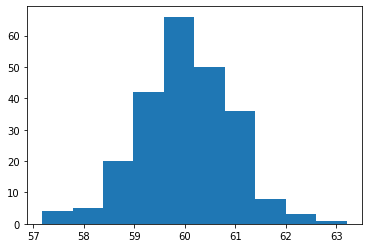

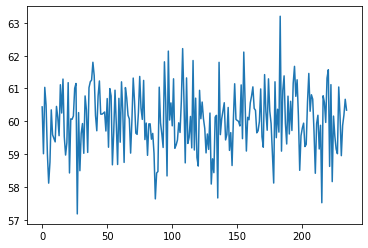

In [3]:
sample_prior = lambda: np.random.normal(loc=60)
sample_candidate = lambda theta: np.random.normal(loc=theta)
scorer = lambda x, y: (math.exp(-((y - 60)**2)/2)) / (math.exp(-((x - 60)**2)/2))
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 10000, 30)
utils.plot_histogram_and_transitions(normal_samples)

## Effects of Initial Distribution, Convergence Diagnosis and Burn-in Time
In the case of the Gaussian above, our `init_function`(initial distribution) was $\mathcal{N}(60,1)$ which is exactly the same as the distribution we were trying to sample, i.e, we started the chain from the stationary distribution. However in general, we obviously don't have the ability to sample from the distribution we were trying to sample from in the first place! Notice that in the exponential, it goes down drastically from 10 where we started the chain, and oscillates more around lower values.

Now run the following code. As you run it, think about the following questions - Are there some samples we need to ignore at the beginning? Explain what is happening with the Markov Chain based on the parameters we've used and your observations from the state vs iteration plot and tell us approximately how many samples we need to ignore.

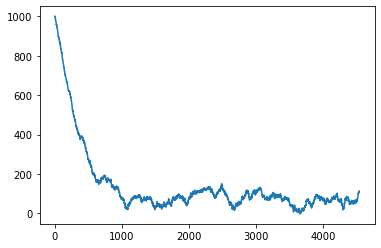

In [4]:
sample_prior = lambda: np.random.normal(loc=1000)
sample_candidate = lambda theta: np.random.normal(loc=theta, scale=3)
normal_pdf = utils.normal(60,30)
scorer = lambda x, y: normal_pdf(y)/normal_pdf(x)
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 5000, 1)
utils.plot_transitions(normal_samples)

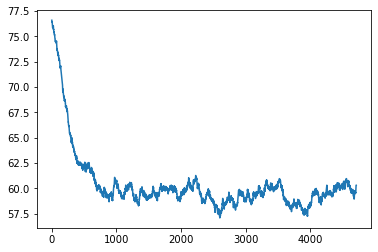

In [5]:
sample_prior = lambda: np.random.normal(loc=75)
sample_candidate = lambda theta: np.random.normal(loc=theta, scale=0.1)
normal_pdf = utils.normal(60,1)
scorer = lambda x, y: normal_pdf(y)/normal_pdf(x)
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 5000, 1)
utils.plot_transitions(normal_samples)

## Roughly 1000 samples.

## Drawbacks of MCMC Techniques

Now we'll evaluate the effectiveness of our sampling technique on a variety of models. The examples below will highlight some of the drawbacks and idiosyncrasies of MCMC techniques. We will look at this in the context of distributions with two peaks (two separated regions of high probability), also known as bimodal distributions. We will see that the peaks may not be sampled appropriately.

## Bimodal Mixture of Gaussians

A mixture of Gaussians is obtained when you have two subpopulations ('classes') each distributed normally($\mathcal{N}(\mu_1,\sigma_1^2)$ and $\mathcal{N}(\mu_2,\sigma_2^2)$) . An example is heights of people with the subclasses of men and women. In the mixture model the 'classes' have probabilities $p$ and $1-p$ respectively. So the pdf of this distribution would be $$p\cdot f_X(x\ |\text{ class 1}) + (1-p)\cdot f_X(x\ |\text{ class 2}) = p\cdot \frac{1}{\sqrt{2\pi \sigma_1^2}} e^{-\frac{(x - \mu_1)^2}{2\sigma_1^2}} + (1-p)\cdot \frac{1}{\sqrt{2\pi \sigma_2^2}} e^{-\frac{(x - \mu_2)^2}{2\sigma_2^2}}
$$

For there to be two peaks in the pdf (to be bimodal), there should be (loosely speaking) sufficient separation between the means with respect to the standard deviations(the widths of the distributions). Otherwise if the peaks are too close relative to the widths, it is possible for the mixture to lead to just one central peak between the two means. There are exact conditions for this you can look up if you are interested. 

*Hints:* 
* *There should be jumps in your transition plots (at least for std devs 4 and 5). Think about what these jumps mean.*
* *As the widths of the peaks grow thinner, how often would you propose a state on the other peak that has a high probability?*
* *How many iterations would we need to tell that we've got samples from both classes a reasonable number of times?*

In [6]:
def sample_from_bimodal(mu1, sigma1, mu2, sigma2, num_iters=10000):
    """Samples from bimodal mixture of Gaussians
    with standard deviation stdev, as described above."""
    
    pdf = utils.gauss_mix(0.5, mu1, sigma1, mu2, sigma2)

    sample_candidate = lambda theta: np.random.normal(loc=theta)
    new_scorer = lambda x,y: pdf(y)/pdf(x) 
    new_prior = lambda : 50

    return metropolis_hastings(sample_candidate, new_prior, new_scorer, num_iters)


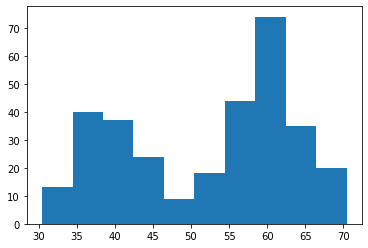

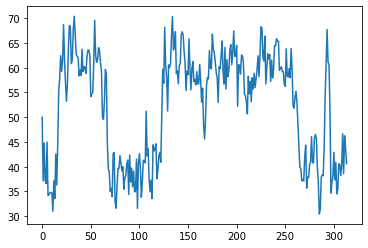

In [7]:
samples = sample_from_bimodal(40, 5, 60, 5)

# plt.figure(figsize=(20, 5))
plt.hist(samples)
plt.show()

# plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(samples)), samples)
plt.show()

## Total Variation Distance

The total variation distance is defined as $\delta(P, Q) = \sup\limits_{A\in\mathcal{F}}|P(A)-Q(A)|$ where $\mathcal{F}$ is all subsets over sample space $\Omega$. It turns out that this reduces to $\delta(P, Q)=\frac{1}{2}\int\limits_{\omega\in\Omega}|f_{P}(\omega)-f_{Q}(\omega)|$

In [8]:
def total_variation_distance(samples1, samples2):
    """ Romberg integration using samples of the density functions.
    Ensure that exactly 2 ** k + 1 evenly spaced samples are created."""
    return 0.5 * integrate.romb(np.abs(samples1 - samples2))

In [9]:
samples = sample_from_bimodal(40, 5, 60, 5, 20000)
X = samples[:, np.newaxis]
X_plot = np.linspace(20, 80, 8193)[:, np.newaxis]
gauss_mix = np.array([utils.gauss_mix(0.5, 40, 5, 60, 5)(x) for x in X_plot]).flatten()

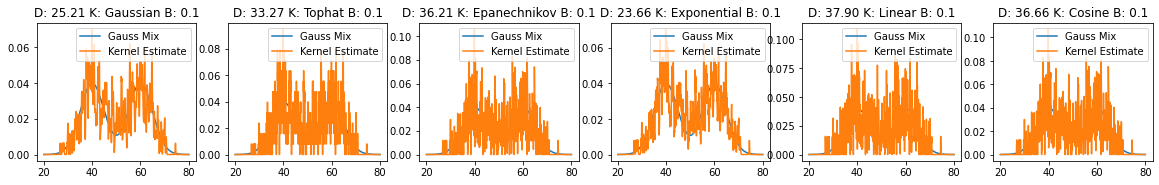

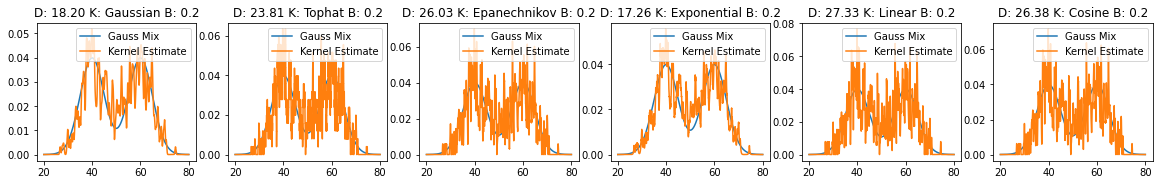

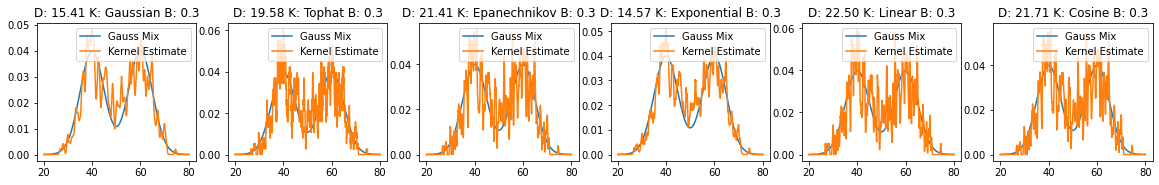

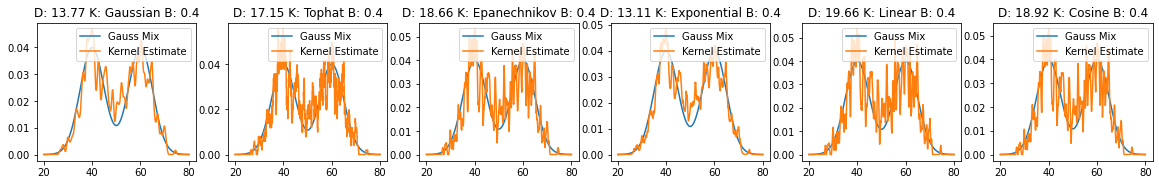

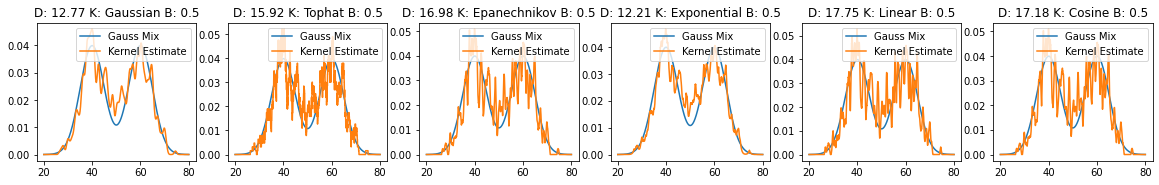

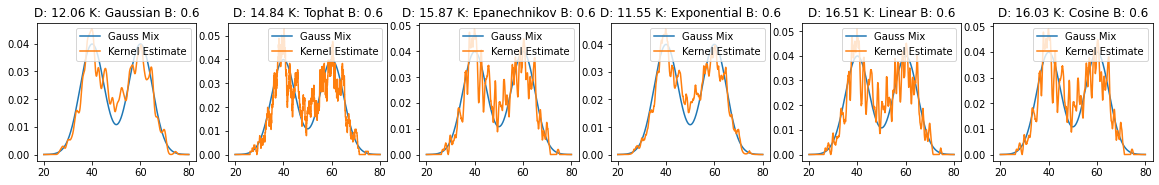

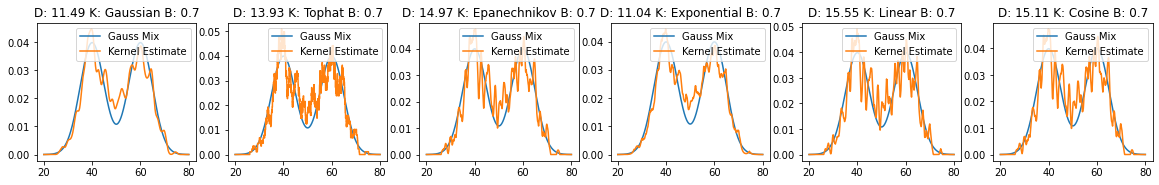

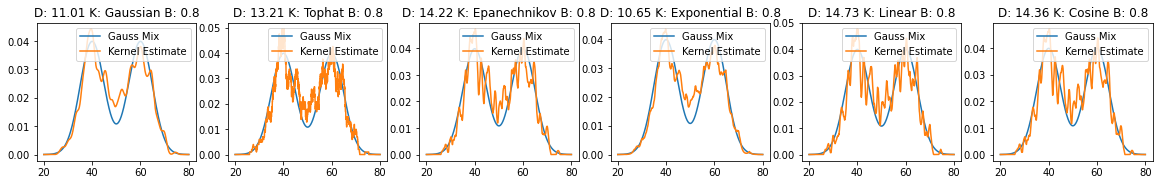

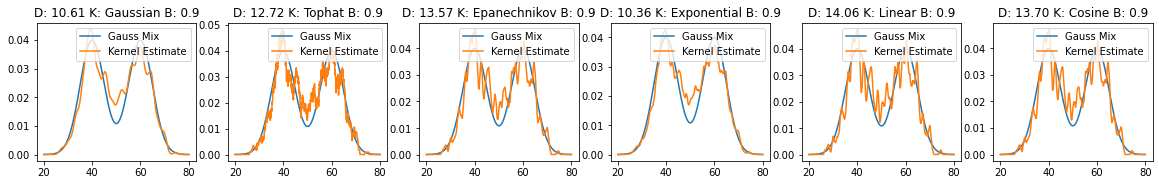

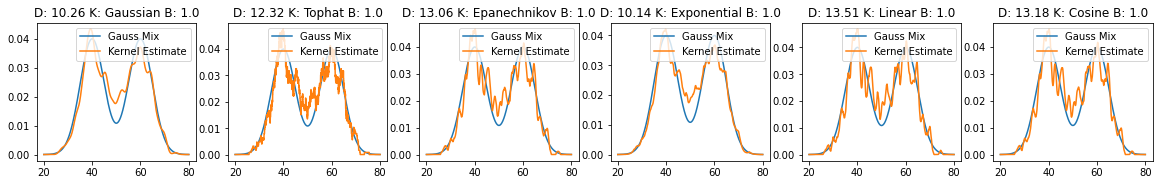

In [50]:
kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
for j in np.arange(0.1, 1.1, 0.1):
    plt.figure(figsize=(20, 30))
    for x, i in enumerate(kernels):
        kde = KernelDensity(kernel=i, bandwidth=j).fit(X)
        estimated_bimodal = np.exp(kde.score_samples(X_plot))

        plt.subplot(10, 6, 6 * int(j * 10 - 1) + x + 1)
        plt.title('D: {:.2f} K: {} B: {:.1f}'.format(
            total_variation_distance(estimated_bimodal, gauss_mix), i.title(), j))
        plt.plot(X_plot[:, 0], gauss_mix, label="Gauss Mix")
        plt.plot(X_plot[:, 0], estimated_bimodal, label="Kernel Estimate")
        plt.legend()
    plt.show()